# Examples
Here we provide some examples with real-world data to examplify the difference between the different approaches.

## Breast Cancer Prediction
In this example, we look at the Breast Cancer dataset from scikit-learn. The classification task is to predict whether the subject has cancer or not.

In [2]:
from pathlib import Path

import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import load_breast_cancer
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler

# Import our custom functions
from src.metrics import create_metrics
from src.cv import run_cv

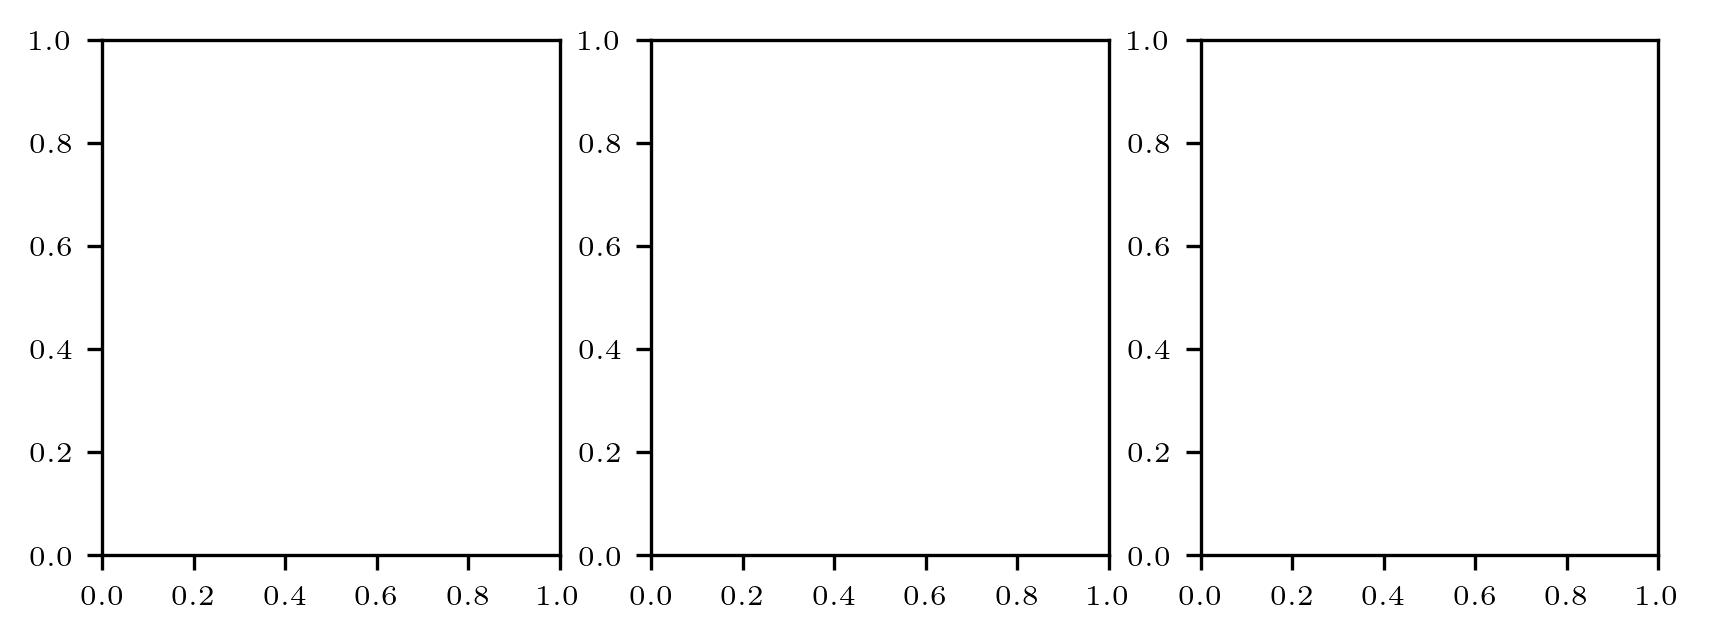

In [25]:
# Functions for plotting
def plot_fold_probs(y_true_folds, y_prob_folds, ax):
    for fold_idx, (y_true, y_prob) in enumerate(zip(y_true_folds, y_prob_folds)):
        y_true = y_true[0]
        y_prob = y_prob[0]
        # true
        ax.scatter(
            [fold_idx] * len(y_prob[y_true == 1]),
            y_prob[y_true == 1],
            c='blue',
            alpha=0.4,
            label=f'Fold {fold_idx + 1}' if fold_idx == 0 else ""
        )
        # false
        ax.scatter(
            [fold_idx] * len(y_prob[y_true == 0]),
            y_prob[y_true == 0],
            c='red',
            alpha=0.4,
            label=f'Fold {fold_idx + 1}' if fold_idx == 0 else ""
        )
    ax.axhline(0.5, color='gray', linestyle='--', label='Decision boundary')
    ax.set_xlabel("Fold")
    ax.set_ylabel("Predicted probability")
    ax.set_title("Predicted probabilities per fold (blue=1, red=0)")

plt.rcParams.update(
    {
        "figure.dpi": 300,
        "font.family": "serif",
        "font.size": 8,
        "axes.labelsize": 9,
        "axes.titlesize": 9,
        "xtick.labelsize": 7,
        "ytick.labelsize": 7,
        "legend.fontsize": 7,
        "lines.linewidth": 1.2,
        "axes.linewidth": 0.8,
        "legend.frameon": False,
        "text.usetex": True,  # Uncomment for LaTeX
        "axes.spines.top": True,
        "axes.spines.right": True,
    }
)
cm = 1 / 2.54
fig_width = 17 * cm
fig_height = 17 * cm / 3
fig, axes = plt.subplots(1,3, figsize=(fig_width, fig_height))

In [3]:
X, y = load_breast_cancer(return_X_y=True)

# print dataset shape
print(f"Dataset shape: {X.shape}")
# Check class balance
print(f"Class distribution:\n{sum(y)} positive, {len(y) - sum(y)} negative, ratio: {sum(y) / len(y):.2f}")

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

Dataset shape: (569, 30)
Class distribution:
357 positive, 212 negative, ratio: 0.63


In [4]:
model = LogisticRegression()
metrics = create_metrics(["accuracy", "rocauc", "prcauc"])
results = run_cv(model, X_scaled, y, metrics, n_splits=5, stratified=True, random_state=1)

results_df = pd.DataFrame({"average": results["average"], "pooled": results["pooled"]})
print(results_df)
print(f"Difference between average and pooled AUC: {results_df['average']['rocauc'] - results_df['pooled']['rocauc']}")

           average    pooled
accuracy  0.978910  0.978910
rocauc    0.995428  0.995098
prcauc    0.996996  0.996543
Difference between average and pooled AUC: 0.00032964443685268296


In [26]:
y_true_folds = results['true']
y_prob_folds = results['probs']

plot_fold_probs(y_true_folds,y_prob_folds,axes[0])


## Cognitive Impairment
In this example, we look at the Oasis3 data. We have cortical volume for various subjects and sessions that are cognitively normal or impaired. The classification task is to predict whether the subject is cogntiviely normal or not, based on cortical features.

In [ ]:
# Load the dataset
data_path = Path("../data/oasis3_fs_mci.tsv")
df = pd.read_csv(data_path, sep="\t")

print(f"Dataset shape: {df.shape}")

# drop rows that have empty cells / NAs
df = df.dropna(axis=0, how="any")

# only keep first occurence of each subject
df_baseline = df.drop_duplicates(subset=["subject"], keep="first")
print(f"Shape of baseline data: {df_baseline.shape}")

In [ ]:
# split into X
X = df_baseline.drop(columns=["subject", "session", "age", "cognitiveyly_normal"])
X = X.apply(pd.to_numeric, errors="coerce")
X = X.to_numpy()

# standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# and y
y = df_baseline["cognitiveyly_normal"].to_numpy()
y_binary = (y == True).astype(int)

# Check class balance
print(f"Class distribution:\n{sum(y_binary)} positive, {len(y_binary) - sum(y_binary)} negative, ratio: {sum(y_binary) / len(y_binary):.2f}")

In [ ]:
## Run cross-validation
model = LogisticRegression(max_iter=1000000)
metrics = create_metrics(["accuracy", "rocauc", "prcauc"])
results = run_cv(model, X_scaled, y_binary, metrics, n_splits=5, stratified=True, random_state=1)
results_df = pd.DataFrame({"average": results["average"], "pooled": results["pooled"]})
print(results_df)
print(f"Difference between average and pooled AUC: {results_df['average']['rocauc'] - results_df['pooled']['rocauc']}")

## Depression Remission
In this example, we look at the NP1 data. The classification task is to predict whether a patient will achieve remission from depression after a certain period of time.


In [ ]:
# Load the dataset
data_path = Path("../data/np1_fs_mdd_episode.csv")
df = pd.read_csv(data_path, sep=",")

print(f"Dataset shape: {df.shape}")

# drop rows that have empty cells / NAs
df = df.dropna(axis=0, how="any")

# only keep first occurence of each subject
print(f"Shape of baseline data: {df.shape}")

# check class balance


In [ ]:
X = df.drop(columns=["mdd_episode", "diagnosis"])
X = X.to_numpy()

# standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# and y
y = df["mdd_episode"].to_numpy()
y_binary = (y == "Recurrent").astype(int)

# Check class balance
print(f"Class distribution:\n{sum(y_binary)} positive, {len(y_binary) - sum(y_binary)} negative, ratio: {sum(y_binary) / len(y_binary):.2f}")

In [ ]:
## Run cross-validation
model = LogisticRegression(max_iter=1000000)
metrics = create_metrics(["accuracy", "rocauc", "prcauc"])
results = run_cv(model, X_scaled, y_binary, metrics, n_splits=5, stratified=True, random_state=1)
results_df = pd.DataFrame(results)
print(results_df)
print(f"Difference between average and pooled AUC: {results_df['average']['rocauc'] - results_df['pooled']['rocauc']}")